# Ames Housing Project Suggestions

Data science is not a linear process. In this project, in particular, you will likely find that EDA, data cleaning, and exploratory visualizations will constantly feed back into each other. Here's an example:

1. During basic EDA, you identify many missing values in a column/feature.
2. You consult the data dictionary and use domain knowledge to decide _what_ is meant by this missing feature.
3. You impute a reasonable value for the missing value.
4. You plot the distribution of your feature.
5. You realize what you imputed has negatively impacted your data quality.
6. You cycle back, re-load your clean data, re-think your approach, and find a better solution.

Then you move on to your next feature. _There are dozens of features in this dataset._

Figuring out programmatically concise and repeatable ways to clean and explore your data will save you a lot of time.

The outline below does not necessarily cover every single thing that you will want to do in your project. You may choose to do some things in a slightly different order. Many students choose to work in a single notebook for this project. Others choose to separate sections out into separate notebooks. Check with your local instructor for their preference and further suggestions.

## EDA
- **Read the data dictionary.**
- Determine _what_ missing values mean.
- Figure out what each categorical value represents.
- Identify outliers.
- Consider whether discrete values are better represented as categorical or continuous. (Are relationships to the target linear?)

## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?

## Exploratory Visualizations
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).

## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.

## Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

## Business Recommendations
- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?

# Example Directory Structure
Here's how you might structure a project with multiple notebooks.

```
project-2
|__ code
|   |__ 01_EDA_and_Cleaning.ipynb   
|   |__ 02_Preprocessing_and_Feature_Engineering.ipynb   
|   |__ 03_Model_Benchmarks.ipynb
|   |__ 04_Model_Tuning.ipynb  
|   |__ 05_Production_Model_and_Insights.ipynb
|   |__ 06_Kaggle_Submissions.ipynb   
|__ data
|   |__ train.csv
|   |__ test.csv
|   |__ submission_lasso.csv
|   |__ submission_ridge.csv
|__ images
|   |__ coefficients.png
|   |__ neighborhoods.png
|   |__ predictions.png
|__ presentation.pdf
|__ README.md
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
#Get datasets: NB, test is just read but will not be written over until modelling is done
#test = '../datasets/test.csv'
train = '../datasets/train.csv'

In [3]:
# Test = pd.read_csv(test)
df = pd.read_csv(train)
# Target Column
y = df['SalePrice']
# Remove target column
features = [col for col in df.columns if col != 'SalePrice']
# Remove PID and ID as columns
df = df[features[2:]]


In [4]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,0,NaN,NaN,NaN,0,3,2010,WD
1,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,0,NaN,NaN,NaN,0,4,2009,WD
2,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,1,2010,WD
3,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,4,2010,WD
4,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,3,2010,WD


In [5]:
# Checking for nulls
df.isnull().sum().sort_values().tail(30)

##no. nulls similar columns might be related.

##From data dictionary, there are columns with NA columns to signify the absence of the additional ammenities
# Pandas dataframe automatically considers all NA columns as NaN, whereas the columns are actually a category by itself
#Need to check and replace all columns that are not in actual fact <blank>/missing

Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Year Remod/Add       0
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Half Bath       2
Bsmt Full Bath       2
Mas Vnr Area        22
Mas Vnr Type        22
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 2      56
Bsmt Exposure       58
Garage Type        113
Garage Yr Blt      114
Garage Qual        114
Garage Cond        114
Garage Finish      114
Lot Frontage       330
Fireplace Qu      1000
Fence             1651
Alley             1911
Misc Feature      1986
Pool QC           2042
dtype: int64

In [6]:
# If BsmtFin SF 1, SF 2 and total bsmt SF are NaN, total square feet (numeric) should be 0.
df[df['BsmtFin SF 1'].isnull()][['BsmtFin SF 1','Total Bsmt SF', 'BsmtFin SF 2', 'Bsmt Unf SF']]

,BsmtFin SF 1,Total Bsmt SF,BsmtFin SF 2,Bsmt Unf SF
1327,NaN,NaN,NaN,NaN


In [7]:
df=df.fillna({'BsmtFin SF 1':0, 'Total Bsmt SF': 0, 'BsmtFin SF 2':0,'Bsmt Unf SF':0})

In [8]:
# Null in Garage Area linked to null in garage cars
df[df['Garage Area'].isnull()][['Garage Cars']]

,Garage Cars
1712,NaN


In [9]:
# Garage area and car should be set to integer '0' if NaN.
df=df.fillna({'Garage Area':0,'Garage Cars':0})

In [10]:
# Bsmt half or full bathroom, if NaN --> Set to 0.0
df=df.fillna({'Bsmt Half Bath':0.0, 'Bsmt Full Bath': 0.0})

In [11]:
# Masonry veneer type if NaN, set to None
# Masonry veneer area if NaN, set to '0'
df=df.fillna({'Mas Vnr Type':'None', 'Mas Vnr Area': 0.0})

In [12]:
# BsmtFin Type 1 and Type 2, Bsmt Qual, Cond and Exposure if NaN, set to "None"
df=df.fillna({'BsmtFin Type 1':'None',
              'BsmtFin Type 2':'None',
              'Bsmt Qual':'None',
              'Bsmt Cond':'None',
              'Bsmt Exposure':'None'
             })

In [13]:
# isnull for Garage type != Garage qual/cond/fin ----> 113 != 114;
# There is a row with garage type = Detchd but no quality, condition, finish and yr Belt
df[df['Garage Qual'].isnull()]['Garage Type'].sort_values(ascending = True).head(1)

1712    Detchd
Name: Garage Type, dtype: object

In [14]:
# Show mode of Garage Qual, Cond, Finish and Yr Blt when Garage type == Detchd
garage = df[df['Garage Type'] == 'Detchd'].mode()
garage[['Garage Qual','Garage Cond','Garage Finish', 'Garage Yr Blt']].head(3)

,Garage Qual,Garage Cond,Garage Finish,Garage Yr Blt
0,TA,TA,Unf,1920.0
1,NaN,NaN,NaN,1930.0


In [15]:
garage[['Garage Yr Blt']].median()

Garage Yr Blt    1925.0
dtype: float64

In [16]:
#For Garage type of 'Detached':
# Replace garage quality, condition, finish and year built of index 1712 with mode of each column
df.loc[1712,'Garage Qual'] = 'TA'
df.loc[1712,'Garage Cond'] = 'TA'
df.loc[1712,'Garage Finish'] = 'Unf'
# Mode of garage year built returns both 1920 and 1930. Since multiple modes, we will replace with median
df.loc[1712,'Garage Yr Blt'] = 1925.0

In [17]:
df[['Garage Yr Blt']].mean()

Garage Yr Blt    1978.680083
dtype: float64

In [18]:
# Garage Type, Qual, Cond, Finish set to 'None' if NaN
# Garage Yr Blt set to mean to preserve mean year built
df=df.fillna({'Garage Type':'None',
              'Garage Qual':'None',
              'Garage Cond':'None',
              'Garage Finish':'None',
              'Garage Yr Blt':1978
             })

In [19]:
# Unusual data year 2207; to correct to 2007
df['Garage Yr Blt'].sort_values(ascending = False).head(3)

1699    2207.0
1241    2010.0
144     2010.0
Name: Garage Yr Blt, dtype: float64

In [20]:
# Correcting year 2207 as 2007
df.loc[1699,'Garage Yr Blt'] = 2007.0

In [21]:
# For lot frontage, if NaN, replace value with 0.0 
df=df.fillna({'Lot Frontage': 0.0})

In [22]:
# For Fireplace quality, if fireplace = 0, quality should be 'None' 
df=df.fillna({'Fireplace Qu': 'None'})

In [23]:
# For Fence if NaN, should be 'None' 
df=df.fillna({'Fence': 'None'})

In [24]:
# For Alley if NaN, should be 'None' 
df=df.fillna({'Alley': 'None'})

In [25]:
# For Misc features, if NaN, should be 'None' 
df=df.fillna({'Misc Feature': 'None'})

In [26]:
# For Pool QC, if Pool = 0, quality should be 'None' 
df=df.fillna({'Pool QC': 'None'})

In [27]:
df.isnull().sum().sort_values(ascending = True).head(3)

MS SubClass    0
Fireplaces     0
Functional     0
dtype: int64

In [28]:
#Setting ordinal categories
ordered_shape = ['IR3', 'IR2', 'IR1', 'Reg']
ordered_utilities = ['ELO','NoSeWa','NoSewr','AllPub']
ordered_slope = ['Sev','Mod','Gtl']
ordered_quality = ['None','Po','Fa','TA','Gd','Ex']
ordered_exposure = ['None','No','Mn','Av','Gd']
ordered_bsmt_finish = ['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
ordered_electrical = ['Mix','FuseP','FuseF','FuseA','SBrkr']
ordered_functional = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
ordered_garage_finish = ['None','Unf','RFn','Fin']
ordered_paved = ['N','P','Y']
ordered_fence = ['None','MnWw','GdWo','MnPrv','GdPrv']

In [29]:
#All ordinal columns
ordinal_cols = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond',
                'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu',
               'Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [ ]:
#Changing type to category for ordinal columns and value from data dictionary
df['Lot Shape'] = df['Lot Shape'].astype("category",ordered=True,categories=ordered_shape).cat.codes
df['Utilities'] = df['Utilities'].astype("category",ordered=True,categories=ordered_utilities).cat.codes
df['Land Slope'] = df['Land Slope'].astype("category",ordered=True,categories=ordered_slope).cat.codes
df['Exter Qual'] = df['Exter Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Exter Cond'] = df['Exter Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Qual'] = df['Bsmt Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Cond'] = df['Bsmt Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Exposure'] = df['Bsmt Exposure'].astype("category",ordered=True,categories=ordered_exposure).cat.codes
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['Heating QC'] = df['Heating QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Electrical'] = df['Electrical'].astype("category",ordered=True,categories=ordered_electrical).cat.codes
df['Kitchen Qual'] = df['Kitchen Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Functional'] = df['Functional'].astype("category",ordered=True,categories=ordered_functional).cat.codes
df['Fireplace Qu'] = df['Fireplace Qu'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Finish'] = df['Garage Finish'].astype("category",ordered=True,categories=ordered_garage_finish).cat.codes
df['Garage Qual'] = df['Garage Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Cond'] = df['Garage Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Paved Drive'] = df['Paved Drive'].astype("category",ordered=True,categories=ordered_paved).cat.codes
df['Pool QC'] = df['Pool QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Fence'] = df['Fence'].astype("category",ordered=True,categories=ordered_fence).cat.codes


In [32]:
num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object']
cat_cols = [cols for cols in df.columns if df[cols].dtypes == 'object']

## EDA
- **Read the data dictionary.**
- Determine _what_ missing values mean.
- Figure out what each categorical value represents.
- Identify outliers.
- Consider whether discrete values are better represented as categorical or continuous. (Are relationships to the target linear?)

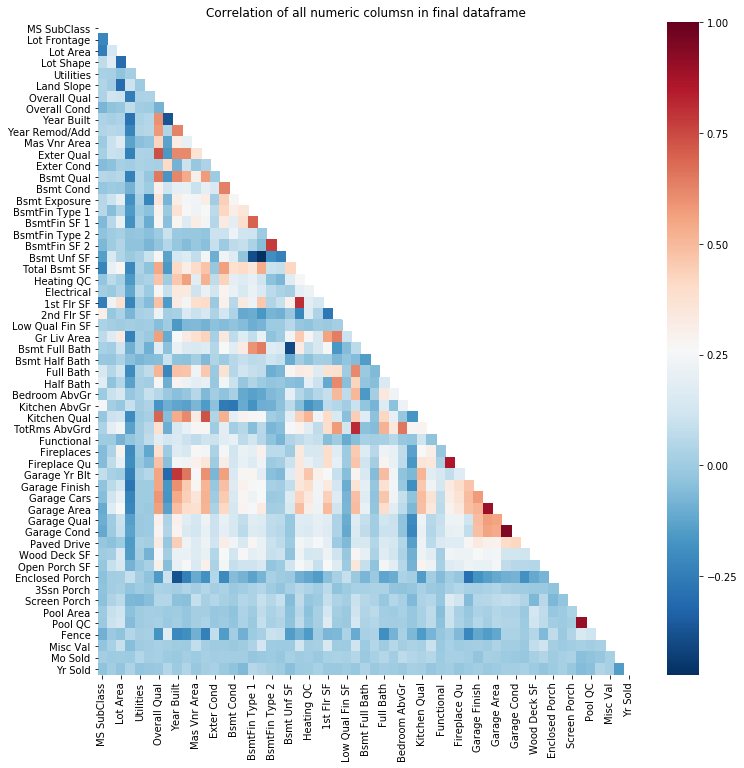

In [35]:
fig, ax = plt.subplots(figsize=(12,12))
# Compute the correlation matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(),mask = mask, cmap="RdBu_r")
ax.set_title('Correlation of all numeric columsn in final dataframe')

plt.show()

In [39]:
corr = df.corr().abs()
unstack_corr = corr.unstack()
corr_sort = unstack_corr.sort_values(ascending = False)

print(corr_sort[56:80])

MS SubClass     MS SubClass       1.000000
Garage Cond     Garage Qual       0.950124
Garage Qual     Garage Cond       0.950124
Pool Area       Pool QC           0.904689
Pool QC         Pool Area         0.904689
Garage Cars     Garage Area       0.893442
Garage Area     Garage Cars       0.893442
Fireplaces      Fireplace Qu      0.859734
Fireplace Qu    Fireplaces        0.859734
Gr Liv Area     TotRms AbvGrd     0.813333
TotRms AbvGrd   Gr Liv Area       0.813333
1st Flr SF      Total Bsmt SF     0.808351
Total Bsmt SF   1st Flr SF        0.808351
Garage Yr Blt   Year Built        0.790920
Year Built      Garage Yr Blt     0.790920
BsmtFin SF 2    BsmtFin Type 2    0.777778
BsmtFin Type 2  BsmtFin SF 2      0.777778
Overall Qual    Exter Qual        0.740257
Exter Qual      Overall Qual      0.740257
                Kitchen Qual      0.730562
Kitchen Qual    Exter Qual        0.730562
BsmtFin SF 1    BsmtFin Type 1    0.699386
BsmtFin Type 1  BsmtFin SF 1      0.699386
Kitchen Qua

## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?


In [112]:
num_cols = [cols for cols in df[num_cols].columns if 'Year' not in cols and 'Yr' not in cols]

array([[1.74904089, 0.51207108, 1.05196316, ..., 0.47543938, 0.08996769,
        1.1734018 ],
       [0.45109431, 0.21166364, 1.05196316, ..., 0.47543938, 0.08996769,
        0.80897917],
       [0.30352579, 0.31794355, 0.71364768, ..., 0.47543938, 0.08996769,
        1.90224708],
       ...,
       [0.02850705, 0.37194271, 0.71364768, ..., 0.47543938, 0.08996769,
        1.1734018 ],
       [0.66574344, 0.04966615, 0.71364768, ..., 0.47543938, 0.08996769,
        1.7419793 ],
       [0.06204736, 0.38054698, 0.71364768, ..., 0.47543938, 0.08996769,
        0.08013389]])

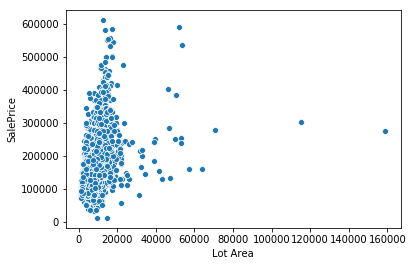

In [68]:
sns.scatterplot(df['Lot Area'],y)

In [70]:
#index 471 and 694 lot area too big
df['Lot Area'].sort_values(ascending = False).head()

471     159000
694     115149
1854     70761
960      63887
745      57200
Name: Lot Area, dtype: int64

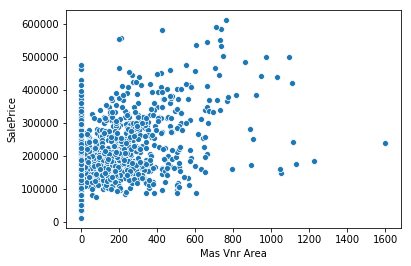

In [71]:
sns.scatterplot(df['Mas Vnr Area'],y)

In [72]:
#index 1409 Mas Vnr Area too big
df['Mas Vnr Area'].sort_values(ascending = False).head()

1409    1600.0
1885    1224.0
1151    1129.0
378     1115.0
489     1110.0
Name: Mas Vnr Area, dtype: float64

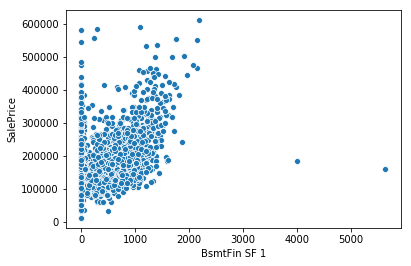

In [73]:
sns.scatterplot(df['BsmtFin SF 1'],y)

In [74]:
#index 960,1885 Mas Vnr Area too big 
#same for BsmtFin SF 2
# same for total bsmt sf
# same 1st flr sf
# same for Gr Liv Area
df['BsmtFin SF 1'].sort_values(ascending = False).head()

960     5644.0
1885    4010.0
1671    2188.0
685     2158.0
623     2146.0
Name: BsmtFin SF 1, dtype: float64

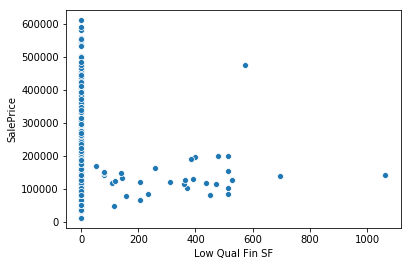

In [87]:
sns.scatterplot(df['Low Qual Fin SF'],y)

In [88]:
#index 828
#same for enclosed porch
df['Low Qual Fin SF'].sort_values(ascending = False).head()

828     1064
1239     697
1035     572
320      528
858      515
Name: Low Qual Fin SF, dtype: int64

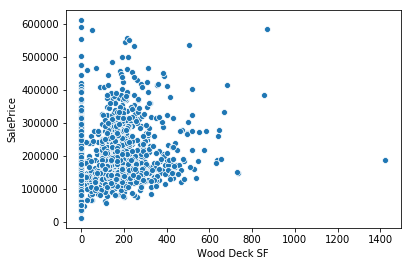

In [93]:
sns.scatterplot(df['Wood Deck SF'],y)

In [94]:
#index 966
df['Wood Deck SF'].sort_values(ascending = False).head()

966     1424
1692     870
1571     857
40       736
1131     728
Name: Wood Deck SF, dtype: int64

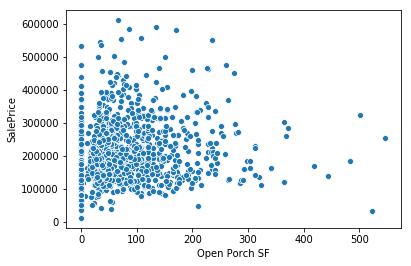

In [95]:
sns.scatterplot(df['Open Porch SF'],y)

In [97]:
#index 974
df['Open Porch SF'].sort_values(ascending = False).head(10)

974     547
1309    523
1141    502
1885    484
610     444
1174    418
616     372
1719    368
569     365
61      364
Name: Open Porch SF, dtype: int64

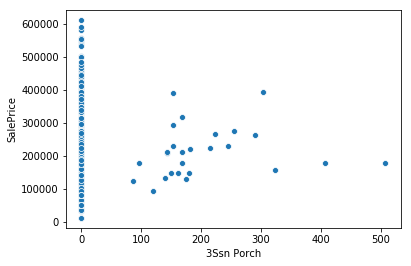

In [103]:
sns.scatterplot(df['3Ssn Porch'],y)

In [104]:
#index 1219, 892, 1577
df['3Ssn Porch'].sort_values(ascending = False).head(10)

1219    508
892     407
1577    323
2045    304
2028    290
1142    255
1903    245
144     224
1696    216
1926    182
Name: 3Ssn Porch, dtype: int64

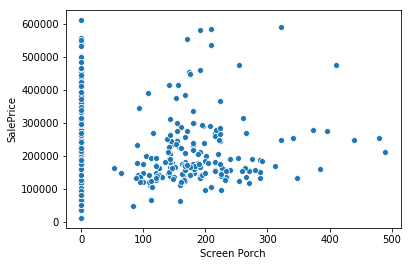

In [105]:
sns.scatterplot(df['Screen Porch'],y)

In [106]:
#index 1357, 974, 52
df['Screen Porch'].sort_values(ascending = False).head()

1357    490
974     480
52      440
1035    410
1947    396
Name: Screen Porch, dtype: int64

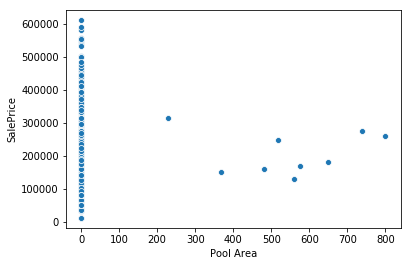

In [107]:
sns.scatterplot(df['Pool Area'],y)

In [109]:
#index 761, 1249, 1130, 657, 1875, 52, 960 , 1635, 952
df['Pool Area'].sort_values(ascending = False).head(10)

761     800
1249    738
1130    648
657     576
1875    561
52      519
960     480
1635    368
952     228
681       0
Name: Pool Area, dtype: int64

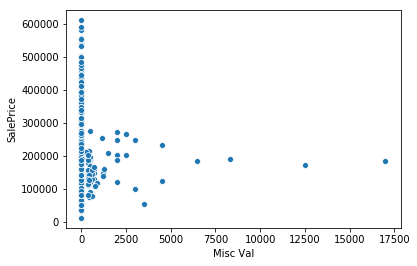

In [110]:
sns.scatterplot(df['Misc Val'],y)

In [111]:
#index 1885, 304, 765, 1225
df['Misc Val'].sort_values(ascending = False).head(10)

1885    17000
304     12500
765      8300
1225     6500
1786     4500
380      4500
700      3500
263      3000
345      3000
1967     2500
Name: Misc Val, dtype: int64

In [ ]:
#Drop outliers > mean + 6.s.d (3491.91)

## Exploratory Visualizations
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).


## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.


## Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

## Business Recommendations
- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?